<div align="center">
<font color="blue"><h1>UAVSAR Radar Path Length Atmospheric Correction</h1>
<h3>Jack Tarricone, September 2021</h3></font></div>

In [2]:
%matplotlib inline
from osgeo import gdal, ogr, osr
import matplotlib.pyplot as plt
from spectral import * # for reading raw envi data
import os
import glob
import re
import codecs
import numpy as np
import subprocess

## Make SLC header

As with all UAVSAR data, the SLC (Single Look Complex) data types comes in a flat binary format with annotation file containing the information needed to properly display and geocode it. Below is a function that searches through the annotation file, pulls out the information needed, and creates an ENVI header. The header allows the data to be read in, visualized, and manipulated in python. 

For the SLC data specifically we know that data type, byte, order, header offset are constant. We just need the number of lines and samples (columns and rows).

In [3]:
gdal.UseExceptions()

#Utility function to load data, we'll use this later

def loadData(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    #Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    #Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
            trans[3] + ysize*trans[5], trans[3]]
    
    ds = None
    return data, extent

def make_slc_header(folder):
    """
    Builds a ENVI header file for SLC UAVSAR data
    Only needs lines and samples
    """
    
    os.chdir(folder)

    # Empty lists to put information that will be recalled later.
    Lines_list = []
    Samples_list = []
    Files_list = []

    # Step 1: Look through folder and determine how many different flights there are
    # by looking at the HDR files.
    for files in os.listdir(folder):
        if files [-4:] == ".lkv" or files [-4:] == ".llh":
            newfile = open(files + ".hdr", 'w')
            newfile.write("""ENVI
description = UAVSAR SLC Header
samples = NSAMP
lines = NLINE
bands = 3
header offset = 0
data type = 4
interleave = bip
sensor type = UAVSAR L-Band
byte order = 0
                """)
            newfile.close()
            if files[0:9] not in Files_list:
                Files_list.append(files[0:9])

    #Variables used to recall indexed values.
    var1 = 0
    
    #Step 2: Look through the folder and locate the annotation file(s).
    # These can be in either .txt or .ann file types. 
    for files in os.listdir(folder):
        if Files_list[var1] and files[-4:] == ".txt" or files[-4:] == ".ann":
            #Step 3: Once located, find the info we are interested in and append it to
            # the appropriate list. We limit the variables to <=1 so that they only
            # return two values (one for each polarization of
            searchfile = codecs.open(files, encoding = 'windows-1252', errors='ignore')
            for line in searchfile:
                if "llh_1_2x8.set_rows" in line:
                    Lines = line[75:81]
                    print(f"Number of Lines: {Lines}")
                    if Lines not in Lines_list:
                        Lines_list.append(Lines)

                elif "llh_1_2x8.set_cols" in line:
                    Samples = line[75:81]
                    print(f"Number of Samples: {Samples}")
                    if Samples not in Samples_list:
                        Samples_list.append(Samples)
                 
            #Reset the variables to zero for each different flight date.
            var1 = 0
            searchfile.close()


    # Step 3: Open .hdr file and replace data 
    
    for files in os.listdir(folder):
        if files[-4:] == ".hdr":
            with open(files, "r") as sources:
                lines = sources.readlines()
            with open(files, "w") as sources:
                for line in lines:
                    if "lines" in line:
                        sources.write(re.sub(line[8:13], Lines, line))
                    elif "samples" in line:
                        sources.write(re.sub(line[10:15], Samples, line))
                    else:
                        sources.write(re.sub(line, line, line))
    
    print(".hdr has been created")
    return


In [7]:
folder = ('/Users/jacktarricone/ch1_jemez_data/feb12-19_slc/BU') # path to folder where .ann and .lvk are
#make_slc_header(folder)

## Load raw binary SLC data

Using the newly created header use the ```envi.open``` function which reads in the 3 band raster file by calling in the header.

### Look Vector (.lvk)

In [8]:
# read in look vector raster
os.chdir(folder)
lvk = envi.open("alamos_35915_03_BU_s1_2x8.lkv.hdr")

In [18]:
lvk # check meta data

	Data Source:   './alamos_35915_03_BU_s1_2x8.lkv'
	# Rows:           8628
	# Samples:        4895
	# Bands:             3
	Interleave:        BIP
	Quantization:  32 bits
	Data format:   float32

From the [SLC data format](https://uavsar.jpl.nasa.gov/science/documents/stack-format.html) infomation, the look vector data is organized east (band 1), north (band 2), up (band 3)

In [9]:
# band 1, east
lvk_open = lvk.open_memmap(writeable = True) # use open.memmap for binary numpy files
east = lvk_open[:,:,0] # slice out first layer

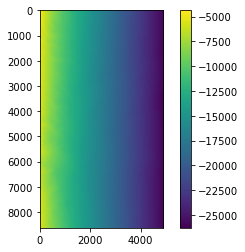

In [10]:
plt.imshow(east) # test plot
plt.colorbar()

In [21]:
# save the individual band using the by creating a header and saving back to binary format

east_hdr = os.path.join(folder, 'east.lvk.hdr')
envi.save_image(east_hdr, east, ext='', interleave='bsq')

In [22]:
# check to see that our saving was correct by reading the single layer back in and plotting it

read_back = envi.open('east.lvk.hdr')
check = read_back.open_memmap(writeable = True) # use open.memmap for binary numpy files
east_check = check[:,:,0]
east_check

memmap([[ -4393.1973,  -4400.964 ,  -4408.824 , ..., -25998.62  ,
         -26002.121 , -26005.625 ],
        [ -4394.163 ,  -4401.9814,  -4409.8433, ..., -25998.676 ,
         -26002.18  , -26005.682 ],
        [ -4395.1167,  -4402.999 ,  -4410.8623, ..., -25998.734 ,
         -26002.236 , -26005.738 ],
        ...,
        [ -5414.2764,  -5421.008 ,  -5427.4067, ..., -26107.398 ,
         -26110.96  , -26114.523 ],
        [ -5414.0586,  -5420.874 ,  -5427.406 , ..., -26107.398 ,
         -26110.969 , -26114.54  ],
        [ -5413.843 ,  -5420.742 ,  -5427.405 , ..., -26107.398 ,
         -26110.979 , -26114.557 ]], dtype=float32)

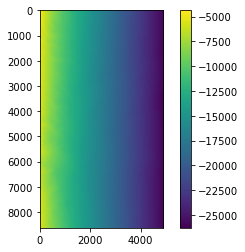

In [23]:
plt.imshow(check) # yup
plt.colorbar()

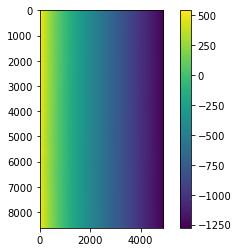

In [24]:
# north
north = lvk_open[:,:,1] # slice nroth first layer
plt.imshow(north)
plt.colorbar()

In [25]:
# save north layer
north_hdr = os.path.join(folder, 'north.lvk.hdr') # change name
envi.save_image(north_hdr, north, ext='', interleave='bsq')

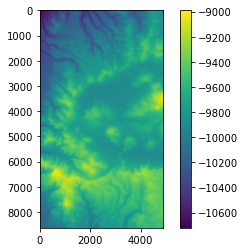

In [26]:
# up
up = lvk_open[:,:,2] # slice out up layer
plt.imshow(up)
plt.colorbar()

In [27]:
# save up band
up_hdr = os.path.join(folder, 'up.lvk.hdr') # change name
envi.save_image(up_hdr, up, ext='', interleave='bsq')

## Lat/Lon/Height (.llh)
Read and in save each band as individual layer

### lat

In [28]:
# read in .llh raster
os.chdir(folder)
llh = envi.open("alamos_35915_03_BU_s1_2x8.llh.hdr")

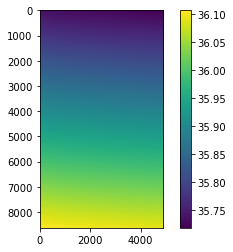

In [29]:
# open band 1, lat
llh_open = llh.open_memmap(writeable = True) # use open.memmap for binary numpy files
lat = llh_open[:,:,0] 
plt.imshow(lat)
plt.colorbar()

In [30]:
# save
lat_hdr = os.path.join(folder, 'lat.llh.hdr')
envi.save_image(lat_hdr, lat, ext='', interleave='bsq')

### lon

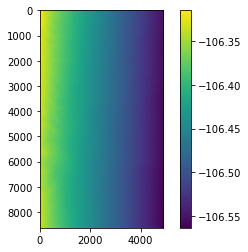

In [31]:
# band 2, lon
llh_open = llh.open_memmap(writeable = True) # use open.memmap for binary numpy files
lon = llh_open[:,:,1] 
plt.imshow(lon)
plt.colorbar()

In [32]:
# save
lon_hdr = os.path.join(folder, 'lon.llh.hdr')
envi.save_image(lon_hdr, lon, ext='', interleave='bsq')

### height (elevation)

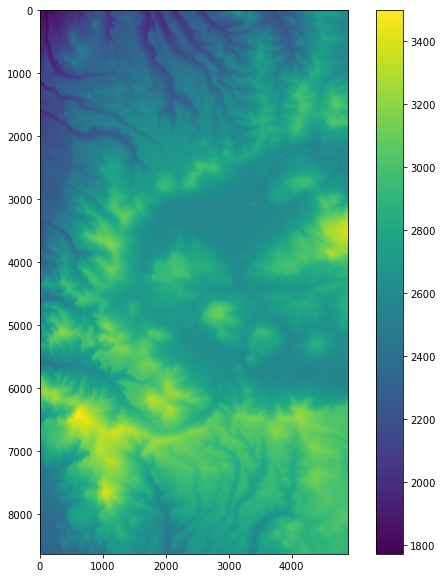

In [33]:
# band 2, lon
llh_open = llh.open_memmap(writeable = True) # use open.memmap for binary numpy files
dem = llh_open[:,:,2] 
plt.figure(figsize=(10,10))
plt.imshow(dem)
plt.colorbar()

In [34]:
# save
dem_hdr = os.path.join(folder, 'dem.llh.hdr')
envi.save_image(dem_hdr, dem, ext='', interleave='bsq')

## Converting to VRT

The ```gdad.Warp``` function that is used to geolocate the SLC needs the data in VRT format. Using the same ```gdal.Translate``` function for for creating GeoTiffs from the InSAR data, we'll output these matrixes into VRTs

In [35]:
# loop to create .vrt for each layer of both data types using gdal.Translate

# .lvk
data_to_process = glob.glob(os.path.join(folder, '*.lvk')) # list all .lvk files
for data_path in data_to_process: # loop to open and translate .lvk to .vrt, and save .vrt using gdal
    raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly)
    raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.vrt'), raster_dataset, format = 'VRT', outputType = gdal.GDT_Float32)
    
# .llh
data_to_process = glob.glob(os.path.join(folder, '*.llh')) # list all .llh files
for data_path in data_to_process: # loop to open and translate .llh to .vrt, and save .vrt using gdal
    raster_dataset = gdal.Open(data_path, gdal.GA_ReadOnly) # read in rasters
    raster = gdal.Translate(os.path.join(folder, os.path.basename(data_path) + '.vrt'), raster_dataset, format = 'VRT', outputType = gdal.GDT_Float32)

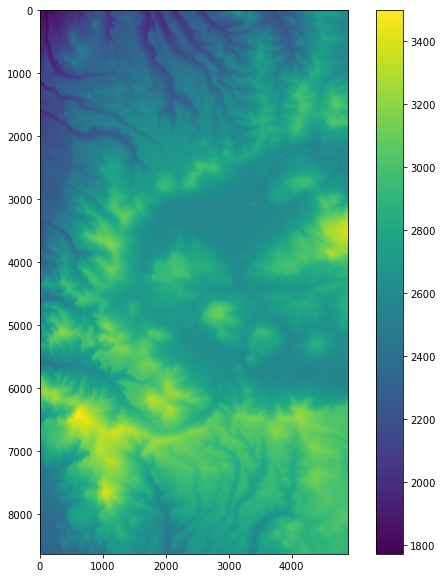

In [42]:
# read data back in using new .vrt and the load data using function we defined in the beginning

test_vrt_path = 'dem.llh.vrt'
test_vrt_path
data, ext = loadData(test_vrt_path)
plt.figure(figsize=(10,10))
plt.imshow(data)
plt.colorbar()
data = None

## Geocoding using geolocation arrays

In this section we will provide programmatic examples of how pixel-by-pixel lon/lat or x/y arrays for swath imagery can be used for directly geocoding the data without any specialized radar processing tools. The main requirement is that these lon/lat or x/y arrays have the same dimensions as the raster image that you are trying to geocode. 

We will achieve this by using the VRT files we created in the previous steps and using the ```gdal.Wap``` function. Within the funciton there's a flag ```geoloc=True``` which vital for initiazling this funcitonality.

In [4]:
# function courtesy of Dr. Gareth Funning, UC Riverside, UNAVCO InSAR Short Course

def geocodeUsingGdalWarp(infile, latfile, lonfile, outfile,
                         insrs=4326, outsrs=None,
                         spacing=None, fmt='GTiff', bounds=None,
                         method='near'):
    '''
    Geocode a swath file using corresponding lat, lon files
    '''
    sourcexmltmpl = '''    <SimpleSource>
      <SourceFilename>{0}</SourceFilename>
      <SourceBand>{1}</SourceBand>
    </SimpleSource>'''
    
    driver = gdal.GetDriverByName('VRT')
    tempvrtname = 'temp_ele.vrt'
    inds = gdal.OpenShared(infile, gdal.GA_ReadOnly)
    
    tempds = driver.Create(tempvrtname, inds.RasterXSize, inds.RasterYSize, 0)
    
    for ii in range(inds.RasterCount):
        band = inds.GetRasterBand(1)
        tempds.AddBand(band.DataType)
        tempds.GetRasterBand(ii+1).SetMetadata({'source_0': sourcexmltmpl.format(infile, ii+1)}, 'vrt_sources')
  
    sref = osr.SpatialReference()
    sref.ImportFromEPSG(insrs)
    srswkt = sref.ExportToWkt()

    tempds.SetMetadata({'SRS' : srswkt,
                        'X_DATASET': lonfile,
                        'X_BAND' : '1',
                        'Y_DATASET': latfile,
                        'Y_BAND' : '1',
                        'PIXEL_OFFSET' : '0',
                        'LINE_OFFSET' : '0',
                        'PIXEL_STEP' : '1',
                        'LINE_STEP' : '1'}, 'GEOLOCATION')
    
    band = None
    tempds = None 
    inds = None
    
    if spacing is None:
        spacing = [None, None]
    
    warpOptions = gdal.WarpOptions(format=fmt,
                                   xRes=spacing[0], yRes=spacing[0],
                                   dstSRS=outsrs, outputBounds = bounds, 
                                   resampleAlg=method, geoloc=True)
    gdal.Warp(outfile, tempvrtname, options=warpOptions)



# save rasters
using the function we just made, save each value to a properly geocode raster. the three look vector components will be used to make a radar path length file

In [55]:
# up
geocodeUsingGdalWarp(infile = 'up.lvk.vrt',
                     latfile = 'lat.llh.vrt',
                     lonfile = 'lon.llh.vrt',
                     outfile = 'geocoded_up.tif',
                     spacing=[.00005556,.00005556])

In [11]:
# north
geocodeUsingGdalWarp(infile = 'north.lvk.vrt',
                     latfile = 'lat.llh.vrt',
                     lonfile = 'lon.llh.vrt',
                     outfile = 'geocoded_north.tif',
                     spacing=[.00005556,.00005556])

In [12]:
# east
geocodeUsingGdalWarp(infile = 'east.lvk.vrt',
                     latfile = 'lat.llh.vrt',
                     lonfile = 'lon.llh.vrt',
                     outfile = 'geocoded_east.tif',
                     spacing=[.00005556,.00005556])

In [13]:
# lon
geocodeUsingGdalWarp(infile = 'lon.llh.vrt',
                     latfile = 'lat.llh.vrt',
                     lonfile = 'lon.llh.vrt',
                     outfile = 'geocoded_lon.tif',
                     spacing=[.00005556,.00005556])

In [14]:
# lat
geocodeUsingGdalWarp(infile = 'lat.llh.vrt',
                     latfile = 'lat.llh.vrt',
                     lonfile = 'lon.llh.vrt',
                     outfile = 'geocoded_lat.tif',
                     spacing=[.00005556,.00005556])

In [ ]:
# dem
geocodeUsingGdalWarp(infile = 'dem.llh.vrt',
                     latfile = 'lat.llh.vrt',
                     lonfile = 'lon.llh.vrt',
                     outfile = 'geocoded_dem.tif',
                     spacing=[.00005556,.00005556])

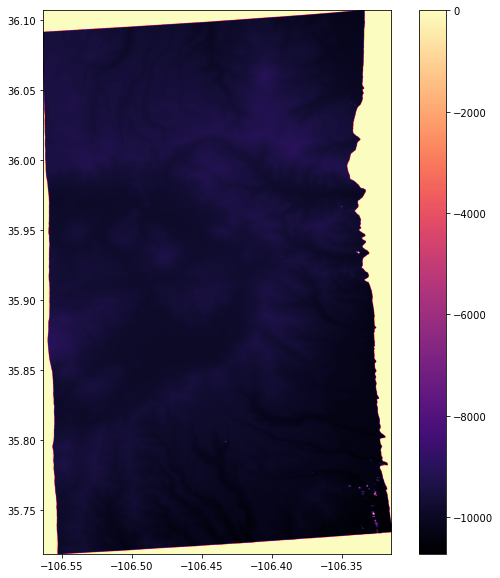

In [56]:
# load back in and test plot

geodata, geoext = loadData('geocoded_up.tif', band=1)

plt.figure(figsize=(10,10))
plt.imshow(geodata, extent=geoext, cmap='magma')
plt.colorbar()

In [57]:
### Create and visualize geocoded output for elevation
# use proper pixel size!

geocodeUsingGdalWarp(infile = 'dem.llh.vrt',
                     latfile = 'lat.llh.vrt',
                     lonfile = 'lon.llh.vrt',
                     outfile = 'geocoded_dem.tif',
                     spacing=[.00005556,.00005556])

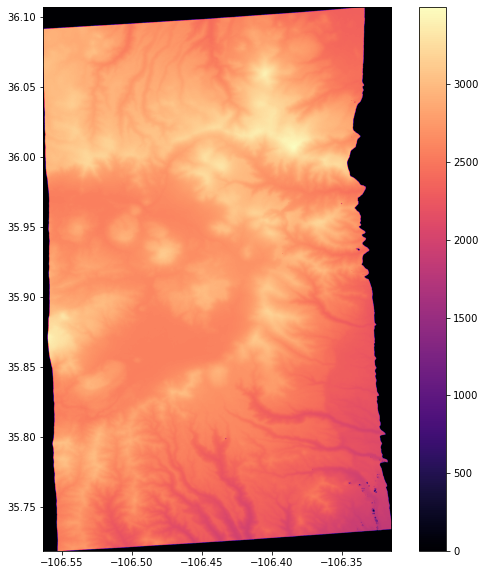

In [58]:
# load back in a test plot the .tif we just created

geodata, geoext = loadData('geocoded_dem.tif', band=1)

plt.figure(figsize=(10,10))
plt.imshow(geodata, extent=geoext, cmap='magma')
plt.colorbar()

In [54]:
# note jan 25th: add loop for creating all six geotiffs